VEHICLE DAMAGE DETECTION USING CNN FINAL

In [ ]:
!pip install tensorflow

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload a zip file with the dataset


Saving datasets.zip to datasets.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile("datasets.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Optional: confirm folders exist
print(os.listdir("datasets"))
print(os.listdir("datasets/train"))


['train', 'validate']
['damaged', 'not_damaged']


In [ ]:
os.listdir()


['.config', 'datasets', 'datasets.zip', 'sample_data']

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_data = datagen.flow_from_directory(
    'datasets/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    'datasets/validate',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


In [ ]:
import os

if os.path.exists('best_model.h5'):
    print("✅ Model file already exists!")
else:
    print("❌ Model file does NOT exist. You need to train the model.")


❌ Model file does NOT exist. You need to train the model.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model_path = '/content/drive/MyDrive/best_model.h5'


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True)
]


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Set model path in Google Drive
model_path = '/content/drive/MyDrive/best_model.h5'

# Define base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True)
]

# Check if model is already saved
if os.path.exists(model_path):
    print("✅ Model already exists. Loading the saved model...")
    model = load_model(model_path)
else:
    print("🚀 Model not found. Starting training now...")
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=35,
        callbacks=callbacks
    )


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Model already exists. Loading the saved model...


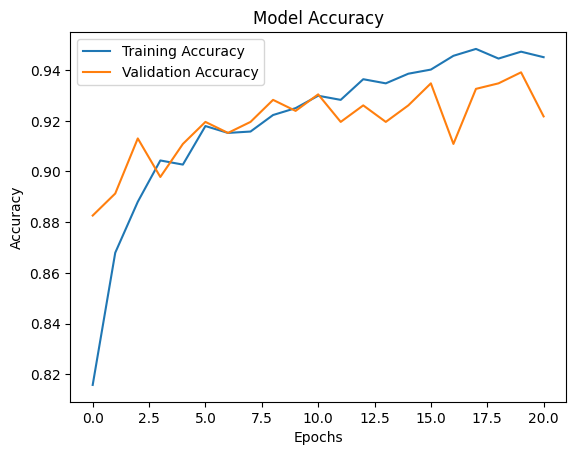

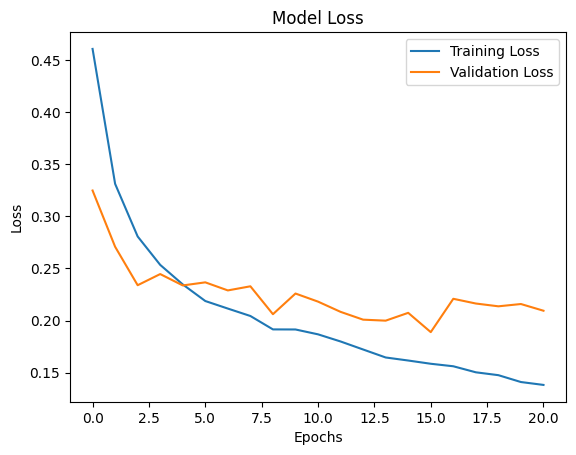

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()


In [ ]:
model.evaluate(val_data)


15/15 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9339 - loss: 0.1901


[0.22132650017738342, 0.9239130616188049]

Saving 0009.jpg to 0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


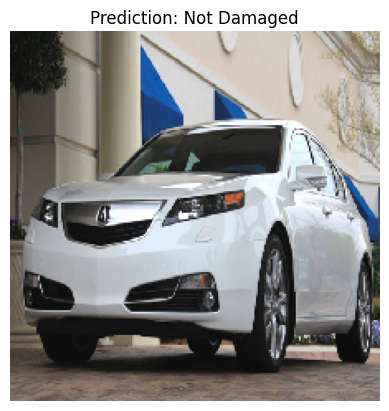

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Upload an image
uploaded = files.upload()

# Load and preprocess the image
for fn in uploaded.keys():
    img_path = fn
    img = image.load_img(img_path, target_size=(224, 224))  # Match training size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize

    # Predict
    prediction = model.predict(img_array)
    result = "Not Damaged" if prediction[0][0] > 0.5 else "Damaged"

    # Show the image and result
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {result}")
    plt.show()


Found 460 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
Classification Report:
              precision    recall  f1-score   support

 Not Damaged       0.94      0.88      0.91       230
     Damaged       0.89      0.94      0.92       230

    accuracy                           0.91       460
   macro avg       0.91      0.91      0.91       460
weighted avg       0.91      0.91      0.91       460



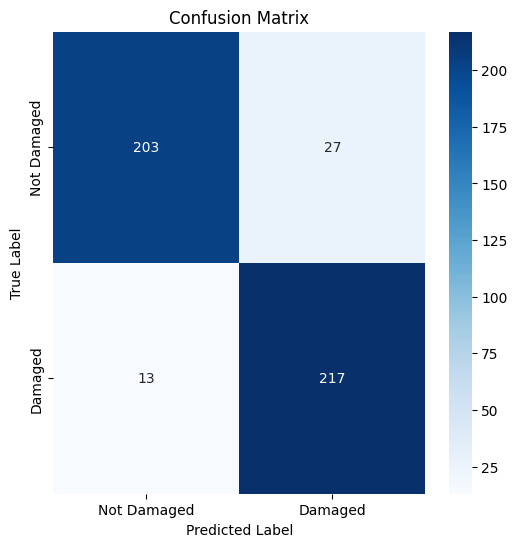

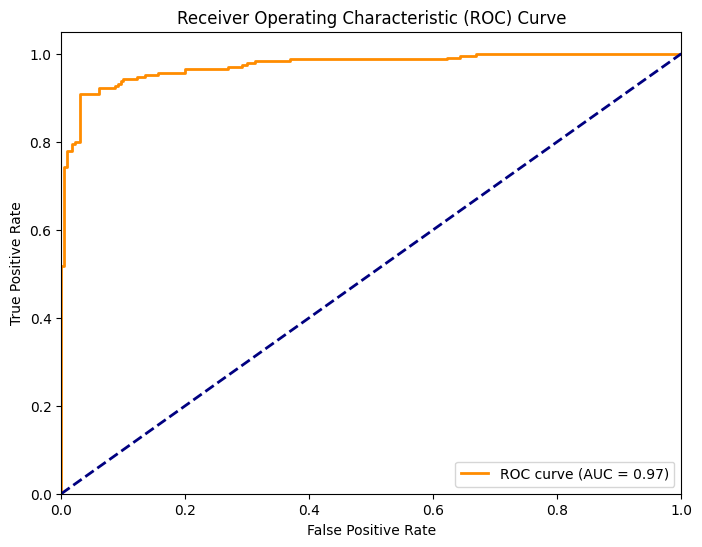

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define class names
class_names = ['Not Damaged', 'Damaged']

# Prepare validation data
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    '/content/datasets/validate',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Predict using the current model
predictions = model.predict(val_generator, verbose=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# True labels
y_true = val_generator.classes

# Classification Report
print("Classification Report:")
print(classification_report(y_true, predicted_labels, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, predicted_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
